In [ ]:
%load_ext autoreload
%autoreload 2

# Qiskit Metal Tutorial for IMS 2022

*Make sure to have the right kernel selected!*

In [ ]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

%metal_heading Welcome to Qiskit Metal!

Welcome to Qiskit Metal! 

For this example tutorial, we will attempt to create a multi qubit chip with a variety of components. We will want to generate the layout, simulate/analyze and tune the chip to hit the parameters we are wanting, and finally rendering to a GDS file.

One could generate subsections of the layout and tune individual components first, but in this case we will create all of the layout. We will be using transmon pockets, meandered and simple transmission lines, capacitive couplers, and launchers for wirebond connections. So we will import these, and also create a design instance and launch the GUI.

We will aim for the following parameters on our chip;

- qubit frequency => 4.8, 5, 5.2 GHz
- qubit anharmonicity => 300 MHz
- qubit-bus (g) => 80 MHz
- qubit-readout (chi) => 1 MHz
- bus frequency (bus_01, bus_02, bus_12) => 5.8, 6.0, 6.2 GHz
- readout frequencies => 6.8, 7, 7.2 GHz
- readout Q_external => 2000

# Layout

In [ ]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_6 import TransmonPocket6

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

from qiskit_metal.qlibrary.lumped.cap_n_interdigital import CapNInterdigital
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

In [ ]:
design = metal.designs.DesignPlanar()

gui = metal.MetalGUI(design)

Since we are likely to be making many changes while tuning and modifying our design, we will enable overwriting. We can also check all of the chip properties to see if we want to change the size of the chip or any other parameter.

In [ ]:
design.overwrite_enabled = True
design.chips.main

For this tutorial, we can say we have a chip of dimensions 6 mm x 6 mm to work with.

In [ ]:
design.chips.main.size.size_x = '6mm'
design.chips.main.size.size_y = '6mm'

### The Qubits

We will add three different transmon pocket qubits to the chip. We can see any options the qubit qcomponent has to figure out what we might want to modify when creating the component. This will include the components default options (which the component designer included) as well as renderer options (which are added based on what renderers are present in your installation of Metal).

We will aim for our qubits to be around 4.8, 5 and 5.2 GHz, for Qubit 0, 1 and 2 respectively, each with anharmonicity of roughly ~300 Mhz. We will aim for a `g` of ~80 MHz to the bus resonators, and a readout `chi` of ~1 MHz. This will require tuning of our layout which we will accomplish later via simulation and analysis, and also explain in more depth.

In [ ]:
TransmonPocket6.get_template_options(design)

In [ ]:
q_0 = TransmonPocket6(design,'Q_0', options = dict(
        pos_x='-1.25mm', 
        pos_y='0.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        pad_width = '425 um', 
        pocket_height = '650um',
        connection_pads=dict(
            readout = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '50um'),
            bus_01 = dict(loc_W=1, loc_H=-1, pad_width = '60um', pad_gap = '10um'),
            bus_02 = dict(loc_W=-1, loc_H=-1, pad_width = '60um', pad_gap = '10um')        
    )))

q_1 = TransmonPocket6(design,'Q_1', options = dict(
        pos_x='1.25mm', 
        pos_y='0.5mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        pad_width = '425 um', 
        pocket_height = '650um',
        connection_pads=dict(
            readout = dict(loc_W=0, loc_H=1, pad_width = '80um', pad_gap = '50um'),
            bus_01 = dict(loc_W=-1, loc_H=-1, pad_width = '60um', pad_gap = '10um'),
            bus_12 = dict(loc_W=1, loc_H=-1, pad_width = '60um', pad_gap = '10um') 
    )))


q_2 = TransmonPocket6(design,'Q_2', options = dict(
        pos_x='0mm', 
        pos_y='-1.35mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        pad_width = '425 um', 
        pocket_height = '650um',
        connection_pads=dict(
            readout = dict(loc_W=0, loc_H=-1, pad_width = '80um', pad_gap = '50um'),
            bus_02 = dict(loc_W=-1, loc_H=1, pad_width = '60um', pad_gap = '10um'),
            bus_12 = dict(loc_W=1, loc_H=1, pad_width = '60um', pad_gap = '10um') 
    )))

gui.rebuild()
gui.autoscale()

### The Busses

We now couple the qubits to each other, primarily using RouteMeander. Although one needs to run simulations to properly tune the line lengths for target frequencies, an initial estimate could be determined from the below method;

In [ ]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

def find_resonator_length(frequency, line_width, line_gap, N): 
    #frequency in GHz
    #line_width/line_gap in um
    #N -> 2 for lambda/2, 4 for lambda/4
    #substrate dimensions and properties already set
    
    [lambdaG, etfSqrt, q] = guided_wavelength(frequency*10**9, line_width*10**-6,
                                              line_gap*10**-6, 750*10**-6, 200*10**-9, 11.9)
    return str(lambdaG/N*10**3)+" mm"

In [ ]:
?guided_wavelength

We will first add the bus resonator between qubits 0 and 1. We can accomplish this easily via the `RouteMeander` qcomponent.
We merely have to state the two pins we wish to have connected, the width/gap of the CPW transmission line, and the total desired length. To determine the pins that we need to input to the route components, we can look at the GUI, or via the pin dictionary of the component, eg.

In [ ]:
q_0.pins.keys()

We will aim for ~5.8 GHz for this bus resonator, which we can find via;

In [ ]:
find_resonator_length(5.8,10,6,2) #Note: What might be wrong with this length?

In [ ]:
bus_01 = RouteMeander(design,'Bus_01', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_0',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_1',
                                                    pin='bus_01')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '10.3mm'))

gui.rebuild()
gui.autoscale()

We now add in two more resonator busses, from Qubit 0 to Qubit 2, and Qubit 1 to Qubit 2. We will target frequencies of ~6 GHz and ~6.2 GHz respectively. We again generate the resonator with `RouteMeander` using minimal options, and change the lead lengths, jogs and asymmetry to have the resonator placed in a manner best fitting the desired overall layout.

In [ ]:
bus_02 = RouteMeander(design,'Bus_02', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_0',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q_2',
                                                    pin='bus_02')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '10mm'))


bus_12 = RouteMeander(design,'Bus_12', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_1',
                                                    pin='bus_12'),
                                                end_pin=Dict(
                                                    component='Q_2',
                                                    pin='bus_12')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '9.7mm'))


gui.rebuild()
gui.autoscale()

We can see these result in some meandered cpws that are not laid out optimally. So we will modify some of the component options, such as the leadin values, and add some jogs to have it laid out in the manner we would like.

In [ ]:
from collections import OrderedDict

bus_01 = RouteMeander(design,'Bus_01', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_0',
                                                    pin='bus_01'),
                                                end_pin=Dict(
                                                    component='Q_1',
                                                    pin='bus_01')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '125um'
                                            ),
                                            meander=Dict(
                                                asymmetry = '-350um'),
                                            fillet = "99um",
                                            total_length = '10.3mm'))


jogs_start = OrderedDict()
jogs_start[0] = ["L", '350um']
jogs_start[1] = ["L", '500um']

bus_02 = RouteMeander(design,'Bus_02', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_0',
                                                    pin='bus_02'),
                                                end_pin=Dict(
                                                    component='Q_2',
                                                    pin='bus_02')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '225um',
                                                start_jogged_extension=jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '-50um'),
                                            fillet = "99um",
                                            total_length = '10mm'))


jogs_start = OrderedDict()
jogs_start[0] = ["R", '350um']
jogs_start[1] = ["R", '700um']

bus_12 = RouteMeander(design,'Bus_12', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_1',
                                                    pin='bus_12'),
                                                end_pin=Dict(
                                                    component='Q_2',
                                                    pin='bus_12')
                                            ),
                                            lead=Dict(
                                                start_straight='325um',
                                                end_straight = '25um',
                                                start_jogged_extension=jogs_start
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '9.7mm'))


gui.rebuild()
gui.autoscale()

### The Readouts and Control Lines

With the qubits placed and connected to each other, we want to start placing the readout and control circuits on to the chip. For this design, we will have the two north transmons multiplexed to a readout line, with Qubit 2 having its own direct readout. So we will need to add three launchpads for wirebonding.

In [ ]:
launch_readout_q_0 = LaunchpadWirebond(design, 'Launch_Readout_Q_0', 
                                       options = dict(pos_x = '-2mm', 
                                                      pos_y ='2.5mm', 
                                                      orientation = '-90'))
launch_readout_q_1 = LaunchpadWirebond(design, 'Launch_Readout_Q_1', 
                                       options = dict(pos_x = '2mm', 
                                                      pos_y ='2.5mm', 
                                                      orientation = '-90'))

launch_readout_q_2 = LaunchpadWirebond(design, 'Launch_Readout_Q_2', 
                                       options = dict(pos_x = '-2mm', 
                                                      pos_y ='-2.5mm', 
                                                      orientation = '90'))

gui.rebuild()
gui.autoscale()

The readout line for qubit 2 will need a capacitor before the readout pad, and the two north qubits will require some form of coupling to the readout transmission line, for which we will use `CapNInterdigitalTee`. We will aim to have a Q_external of ~2000 for the readout resonators, though for the time being we will generate them with the default options and later achieve the desired coupling strength via simulations.

In [ ]:
cap_readout_q_2 = CapNInterdigital(design,'Cap_Readout_Q_2', options = dict(pos_x = '-2mm', pos_y ='-2.25mm', orientation = '0'))

cap_readout_q_0 = CapNInterdigitalTee(design,'Cap_Readout_Q_0', options=dict(pos_x = '-1.5mm', pos_y = '2.25mm', 
                                                           orientation = '0'))

cap_readout_q_1 = CapNInterdigitalTee(design,'Cap_Readout_Q_1', options=dict(pos_x = '1.5mm', pos_y = '2.25mm', 
                                                           orientation = '0'))

gui.rebuild()
gui.autoscale()

We now need to add in the readout resonators by adding meandered lines between the qubits and their respective capacitors we just added. We will aim for readout frequencies of ~6.8, ~7 and ~7.2 GHz. We can look at the GUI to make sure we are referencing the correct pins for the `pin_inputs` options. (We will skip ahead to the well laid out options this time)

In [ ]:
find_resonator_length(7.2,10,6,2)

In [ ]:
jogs_start = OrderedDict()
jogs_start[0] = ["L", '350um']
#jogs_start[1] = ["R", '700um']

readout_0 = RouteMeander(design,'Readout_0', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_0',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Cap_Readout_Q_0',
                                                    pin='second_end')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '25um',
                                                start_jogged_extension=jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '8.8mm'))

jogs_start = OrderedDict()
jogs_start[0] = ["R", '350um']

readout_1 = RouteMeander(design,'Readout_1', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_1',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Cap_Readout_Q_1',
                                                    pin='second_end')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '25um',
                                                start_jogged_extension=jogs_start,
                                                #end_jogged_extension = jogs_end
                                            ),
                                            meander=Dict(
                                                asymmetry = '50um'),
                                            fillet = "99um",
                                            total_length = '8.5mm'))


readout_2 = RouteMeander(design,'Readout_2', options = dict(hfss_wire_bonds = True, 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_2',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Cap_Readout_Q_2',
                                                    pin='north_end')
                                            ),
                                            lead=Dict(
                                                start_straight='125um',
                                                end_straight = '25um',
                                            ),
                                            meander=Dict(
                                                asymmetry = '200um'),
                                            fillet = "99um",
                                            total_length = '8.3mm'))

gui.rebuild()
gui.autoscale()

The remaining sections of CPW tranmission line are all that remain to be added.

In [ ]:
tl_readout_q_2= RouteStraight(design,'TL_Readout_Q_2', options = dict(hfss_wire_bonds = True,
                                           pin_inputs=Dict(
                                               start_pin=Dict(
                                                   component='Cap_Readout_Q_2',
                                                   pin='south_end'),
                                               end_pin=Dict(
                                                    component='Launch_Readout_Q_2',
                                                    pin='tie')),
                                            trace_width = '10um',
                                            trace_gap = '6um'
                                            ))

tl_readout_q_0 = RoutePathfinder(design,'TL_Readout_Q_0', options = dict(hfss_wire_bonds = True,
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Cap_Readout_Q_0',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Launch_Readout_Q_0',
                                                    pin='tie')),
                                            fillet = '99um',
                                            trace_width = '10um',
                                            trace_gap = '6um'
                                            ))

tl_readout_q_1 = RoutePathfinder(design,'TL_Readout_Q_1', options = dict(hfss_wire_bonds = True,
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Cap_Readout_Q_1',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Launch_Readout_Q_1',
                                                    pin='tie')),
                                            fillet = '99um',
                                            trace_width = '10um',
                                            trace_gap = '6um'
                                            ))

tl_readout_q_01= RouteStraight(design,'TL_Readout_Q_01', options = dict(hfss_wire_bonds = True,
                                           pin_inputs=Dict(
                                               start_pin=Dict(
                                                   component='Cap_Readout_Q_0',
                                                   pin='prime_end'),
                                               end_pin=Dict(
                                                    component='Cap_Readout_Q_1',
                                                    pin='prime_start')),
                                            trace_width = '10um',
                                            trace_gap = '6um'
                                            ))

gui.rebuild()
gui.autoscale()

With this, we have successfully generated the layout for our 3 qubit chip. This, however, is just the first step in designing a functional qubit chip, as we now must simulate and analyze the many components in our design and tune their options in order to hit our desired parameters, such as the qubit's anharmonicities or the readout resonator coupling strengths.

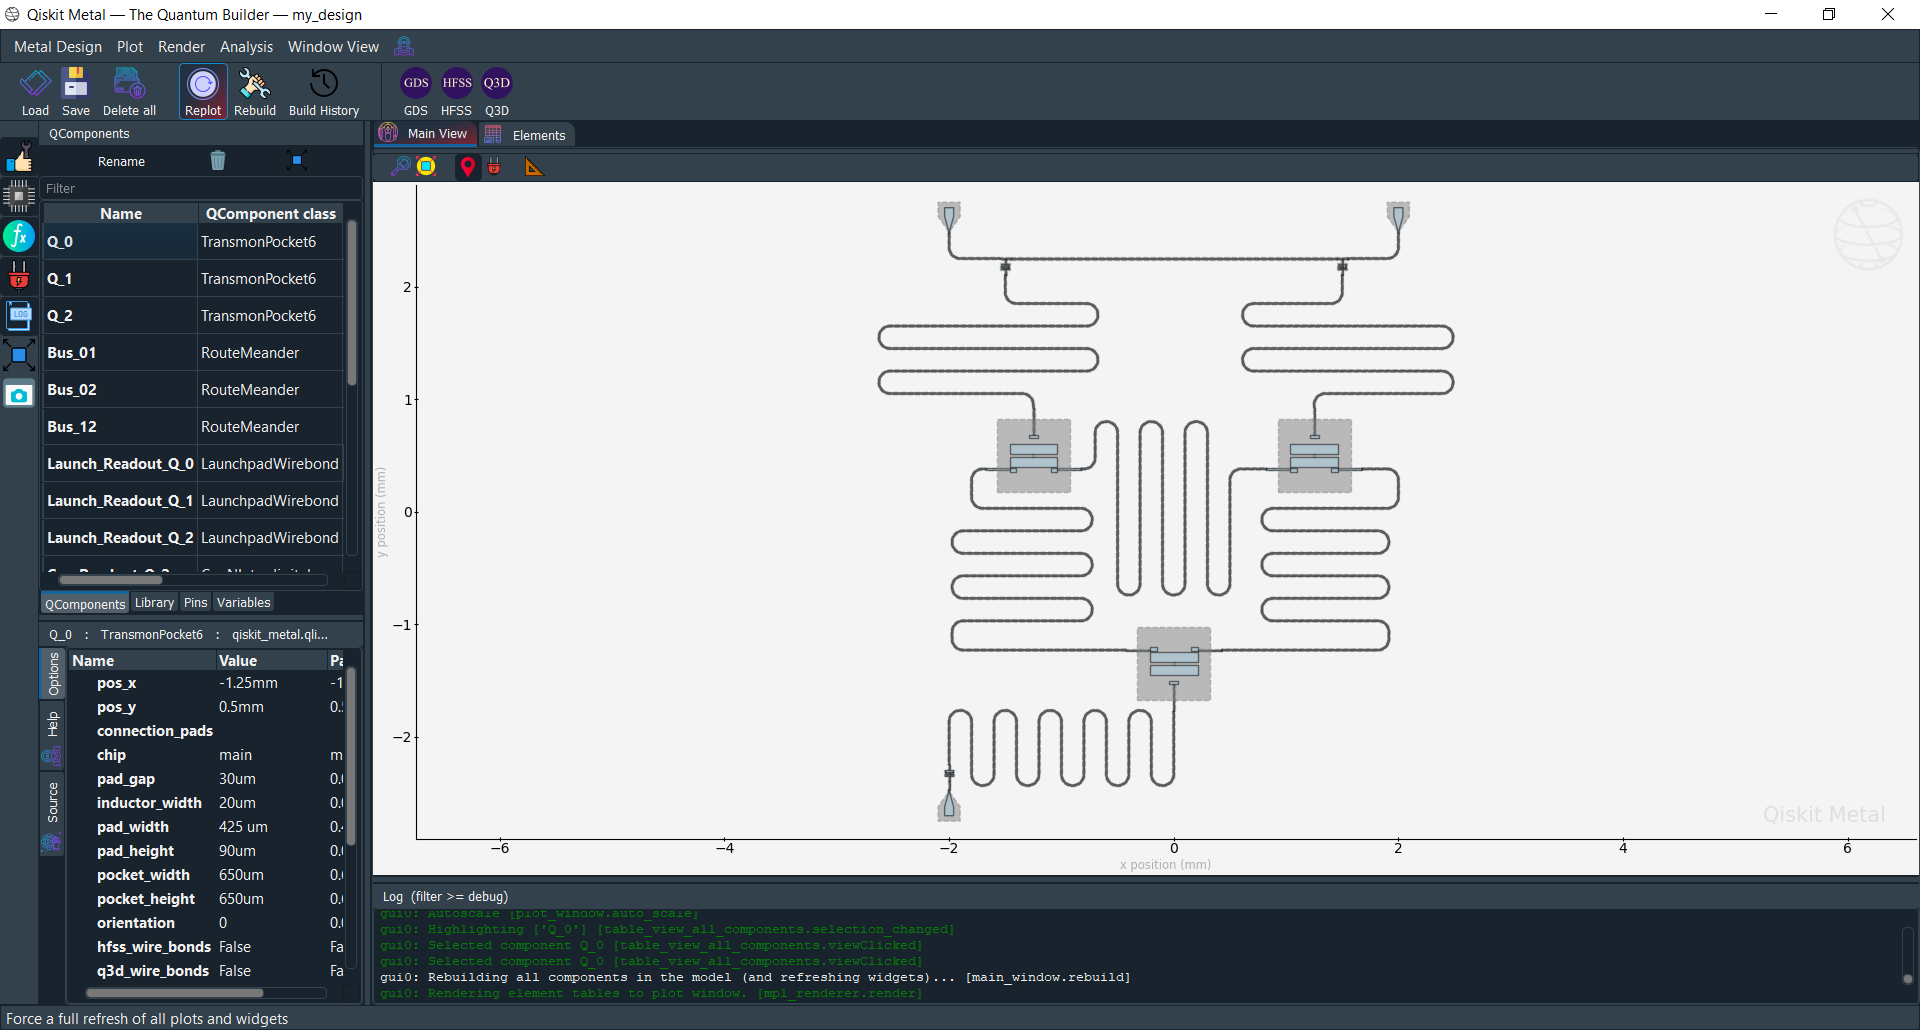

# Simulation and Analysis

With our fully designed chip now laid out, we can start to focus on tuning the components to hit the circuit parameters we are interested in. These will tend to be;
- qubit: frequency, the anharmonicity/alpha, and the coupling strength (as chi, g, or other)
- busses: frequency (if resonant), the coupling strength
- readout: frequency, coupling strength, coupling to external lines (as kappa, Q_external, or other)

All the qubit parameters can initially be tuned via a capacitance matrix and the lumped oscillator method (LOM). This analysis is not as accurate as others, but allows for fairly fast and small simulations. We will start setting up this simulation by rendering the qubit of interest into Ansys Q3D.

As a reminder, our target parameters are (approximately);
- qubit frequency => 4.8, 5, 5.2 GHz
- qubit anharmonicity => 300 MHz
- qubit-bus (g) => 80 MHz
- qubit-readout (chi) => 1 MHz
- bus frequency (bus_01, bus_02, bus_12) => 5.8, 6.0, 6.2 GHz
- readout frequencies => 6.8, 7, 7.2 GHz
- readout Q_external => 2000

Not all of the analysis and tuning that would be required will be followed in this notebook, as that would be very time consuming. We will instead focus on a few specific steps which enable us to look at the difference analysis capabilities in Metal.

## Qubit and Lumped Oscillator Model (LOM) (https://arxiv.org/abs/2103.10344)

We will focus on Qubit 0 for this step of the simulation and analysis. We first import the LOMAnalysis class, and create an instance of it attached to our design. We also indicate which renderer we want to use, in this case `q3d`.

In [ ]:
from qiskit_metal.analyses.quantization import LOManalysis
q_0_LOM = LOManalysis(design, "q3d")

We can check what the simulation default settings are via `q_0_LOM.setup.sim`, and change any that do not meet are requirements.

In [ ]:
q_0_LOM.sim.setup

In addition to the settings for the LOM analysis.

In [ ]:
q_0_LOM.setup

We can see that the default settings for LOM clearly don't match that of our Qubit 0, so we will want to update these to our design values. We do not yet know what the Lj for the qubit should be for our target frequency of 4.8 GHz, but we will determine that as part of this tuning.

In [ ]:
q_0_LOM.setup.freq_readout = 6.8
q_0_LOM.setup.freq_bus = [5.8,6.0]
q_0_LOM.setup

We next want to run the simulation and analysis. We will use a first run to determine if we are achieving good convergence on our quantum parameters, as if we find we are not, we may need to increase the precision of our classical simulation. The time (and memory) it takes for a simulation to complete will depend on many factors: the type of simulation, the number and types of components, the desired accuracy, and available computing power. It is always advisable to do simpler/shorter simulations first to make sure your design is roughly on target, before running long simulations for fine tuning.

We must specify which components we are wanting to include in the simulation/analysis, and how we want any unconnected pins and junctions handled depending on the simulation/analysis we are running.
In this case, we will only render Qubit 0, and terminate the unconnected pins with opens. The junction is automatically ignored in this case since we are only extracting the layout capacitance.

In case have forgotten what the pins for Qubit 0 are;

In [ ]:
q_0.pins.keys()

In [ ]:
q_0_LOM.run(components=['Q_0'], open_terminations=[('Q_0', 'readout'), ('Q_0', 'bus_01'), ('Q_0', 'bus_02')])

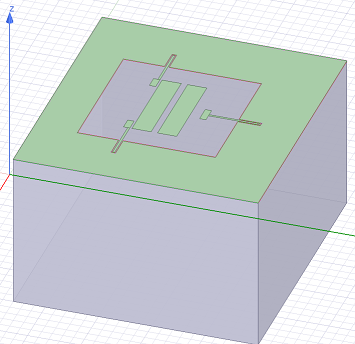

After the run is complete, we can check the convergence plots.

In [ ]:
q_0_LOM.plot_convergence();
q_0_LOM.plot_convergence_chi()

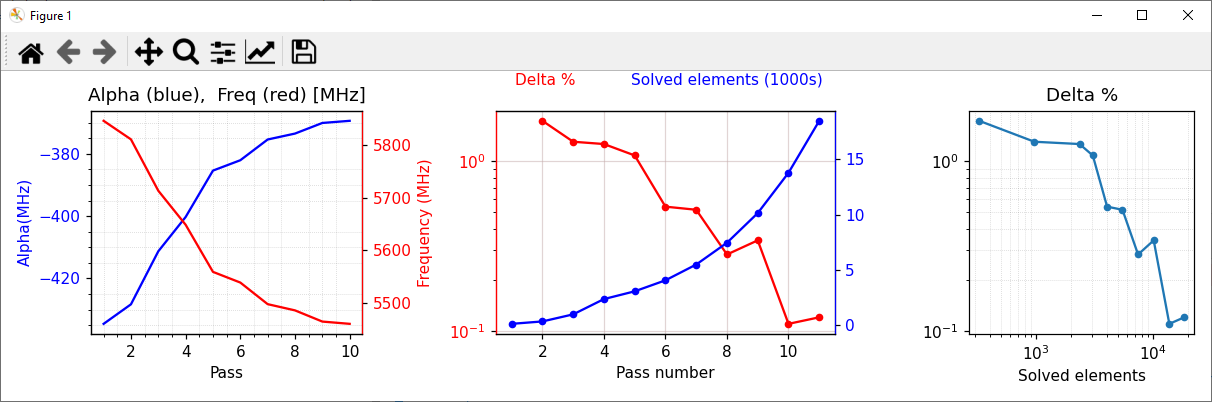

The qubit frequency and anharmonicity have not converged to a degree we would like, such that we should lower the `percent_error` in our simulation setup. We then run the simulation again.

In [ ]:
q_0_LOM.sim.setup.percent_error = 0.1
q_0_LOM.sim.setup.max_passes = 20
q_0_LOM.run()

In [ ]:
q_0_LOM.plot_convergence();
q_0_LOM.plot_convergence_chi()

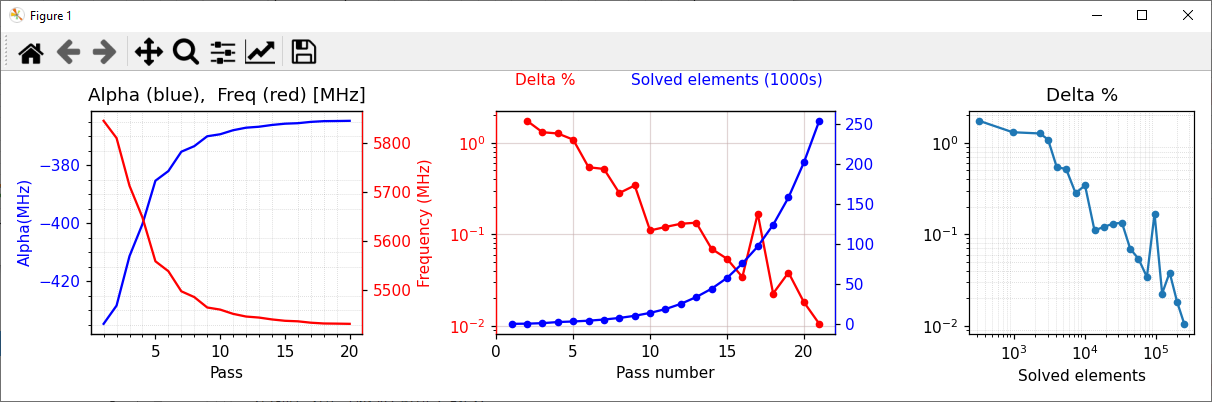

We see that we now have reasonable convergence, and can reasonably trust the analysis results of our qubit in order to start tuning. We could, if so desired, first look at the capacitance matrix, seeing the capacitance values between the different parts of the qubit in the off diagonals (in fF).

In [ ]:
q_0_LOM.sim.capacitance_matrix

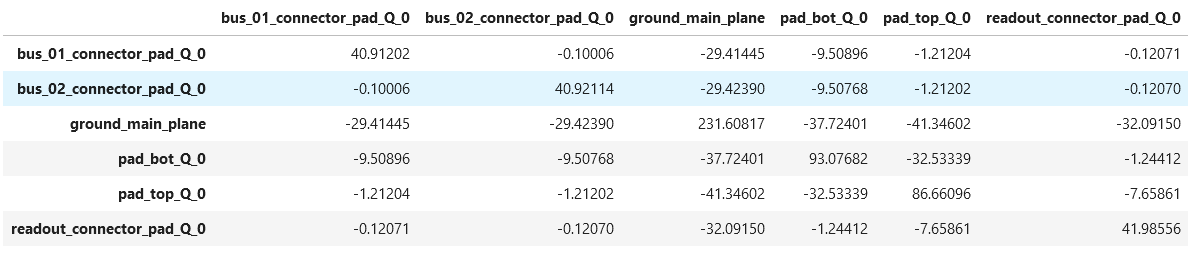

Of more immediate interest, is seeing the resulting parameters of the LOM analysis

In [ ]:
q_0_LOM.lumped_oscillator

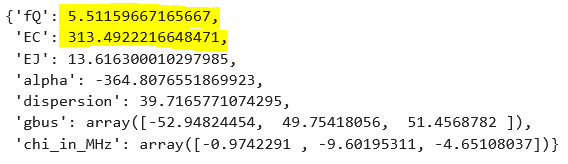

We can see that we are off for many of our target parameters. The anharmonicity is most easily modified by changing the `q_0.options.pad_gap` value, as we wish to change the capacitance seen across the junction. Once the target anharmonicity is reached, we can modify `Lj` to reach the desired qubit frequency. 

After this, we can then start modifying the geometries of the connection pads, such as lowering `q_0.options.connection_pads.readout.pad_gap` in order to increase the readout `chi`. As this process requires multiple steps of simulation and analysis, we will jump ahead to the approximate values I found offline.

In [ ]:
q_0.options.pad_gap = '28um'
q_0.options.connection_pads.readout.pad_gap = '22um'
q_0.options.connection_pads.readout.pad_width = '100um'
q_0.options.connection_pads.bus_01.pad_width = '135um'
q_0.options.connection_pads.bus_02.pad_width = '135um'

q_0_LOM.setup.junctions.Lj = 14.9

gui.rebuild()

In [ ]:
q_0_LOM.run(name="Q_0_LOM_2",components=['Q_0'], open_terminations=[('Q_0', 'readout'), ('Q_0', 'bus_01'), ('Q_0', 'bus_02')])

In [ ]:
q_0_LOM.lumped_oscillator

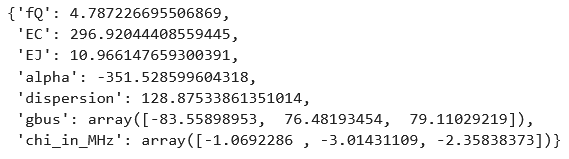

We have successfully tuned Qubit 0 to the approximate target quantum parameters, finding that we need an Lj = 14.9 nH to hit the target frequency, slight modifications to the qubit's pads to hit the anharmonicity and connection pad geometries increased to have a stronger capacitive coupling. In a full design flow we would want to tune the other qubits, but for now we shall jump to tuning `Bus_02`, finding the necessary length to have it be at 6.0 GHz.

In [ ]:
q_0.options.hfss_inductance = '14.9nH'

gui.rebuild()

In [ ]:
q_0_LOM.sim.close()

## Resonator and Eigenmode Simulations

We will focus on `Bus_02` for this step. We first create an instance of a HFSS render, connect it to Ansys, add a design, and modify the options for the simulation we want. We will follow a process similar to the previous tuning, but this time, import the EPR analysis class, then make an instance of it with hfss as the chosen renderer.

In [ ]:
from qiskit_metal.analyses.quantization import EPRanalysis
bus_02_EPR = EPRanalysis(design, "hfss")

We can again check what options are available with the simulation setup. As this is more of a first pass on the resonator frequency to get it to approximately the desired value, we can leave it with most of the default options. We could increase the max passes, and minimum converged passes though. 

It should be noted, the max passes being used here will likely not lead to good convergence, as these are much more complex simulations than we had dealt with previously for the LOM analysis. For this tutorial, we will presume they are converged well, but proper checking of the convergence should be done with any simulation.

In [ ]:
bus_02_EPR.sim.setup

We then renderer the necessary components into the simulation. In this case, we will want Bus_02, Q_0 and Q_2, as we want the coupler components of the resonator that is present in each qubit to be included in the simulation. We can leave all of the open pins on each qubit as shorted (the default), and also remove the sheet inductance representing their Josephson junctions for this tuning. We can also include the entire chip substrate to make sure it isn't big enough to potentially have a chip mode that could couple to our circuits (via `box_plus_buffer = False`). For this reason we will include two modes in our simulation.

We are also only running the simulation, not the full EPR analysis, since we are only interesting in the classical eigenmode of the resonator for this step. We accomplish this by using `bus_02_EPR.run_sim()`.

In [ ]:
bus_02_EPR.sim.setup.n_modes = 2
bus_02_EPR.sim.run_sim(name="Bus_02_Sim", components=['Q_0','Q_2','Bus_02'], 
                   ignored_jjs = [('Q_0','rect_jj'),('Q_2','rect_jj')], 
                   box_plus_buffer = False)

We can look at the simulation convergence as we did previously to see if higher precission is necessary. As we can see below, this simulation did not converge well, so more passes, or finer mesh, really would be necessary. We will continue under the assumption that this simulation did converge well.

In [ ]:
bus_02_EPR.sim.plot_convergences()

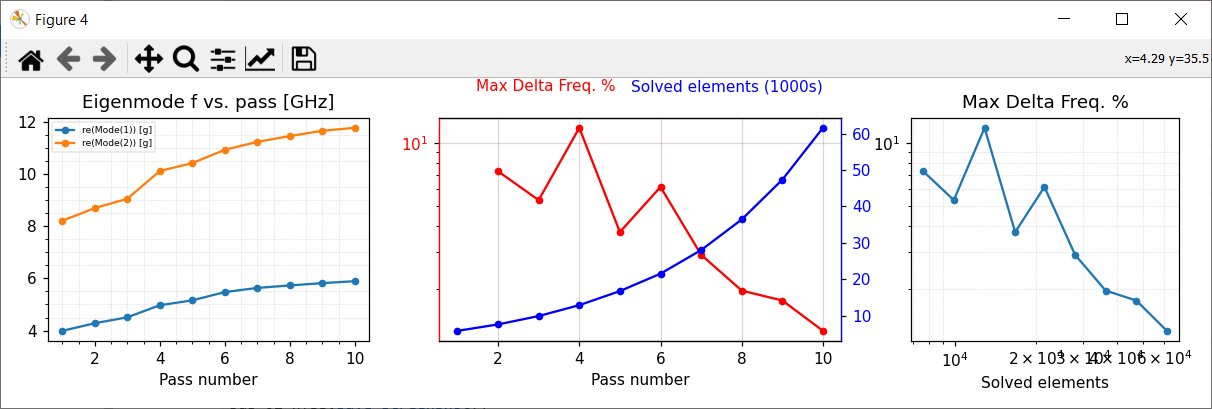

In [ ]:
bus_02_EPR.get_frequencies()

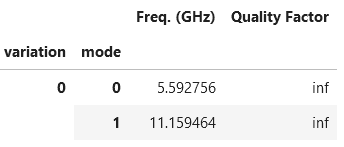

We see, as suspected, that the resonator frequency is a bit lower than initially estimated (since we didn't consider the coupling). We can also confirm that the modes simulated are for the bus resonator and not (potentially) the chip substrate by looking at the E-field distribution, as seen below.

In [ ]:
bus_02_EPR.sim.plot_fields('main')
#bus_02_EPR.sim.save_screenshot()

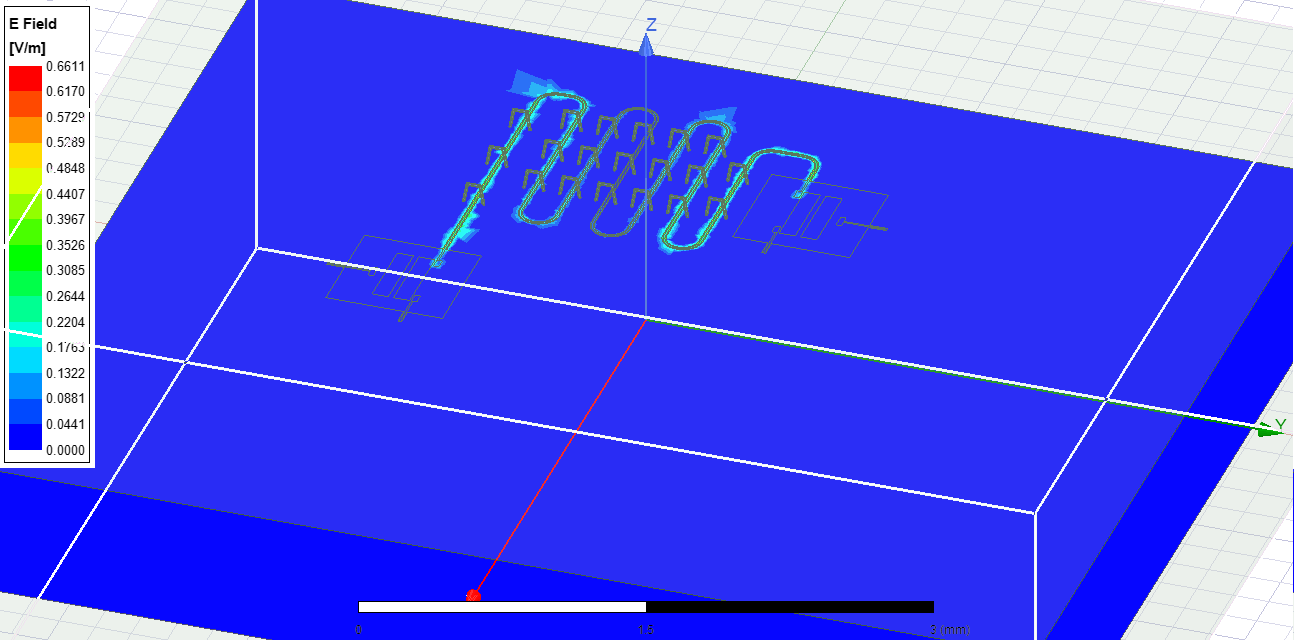

So we will need to lower the value of `bus_02.options.total_length`, to increase its resonant frequency. We can do that via making the changes individually, rerendering, simulating, and looking at the solutions, or we can make use of `sweep_one_option_get_eigenmode_solution_data`.

Focusing on the bus resonator, we will now run a sweep which will check a few different `total_lengths` for Bus 02. First we import and create a sweep instance, then run an eigenmode sweep with options suitable for tuning the resonator length. As these simulations can require a good amount of meshing to hit a reasonable convergence, they will consume a great deal of time and memory.

In [ ]:
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
sweep = Sweeping(design)

We can check what the input options are for running of the sweep class.

In [ ]:
?sweep.sweep_one_option_get_eigenmode_solution_data

We then setup the sweep simulations options, the sweep varaible and values, and what components to render. We will again supress the junctions in this simulation so as to just focus on the bus resonance.

In [ ]:
em_setup_args = Dict(min_freq_ghz=3,
                    n_modes=1,
                    max_passes=12,
                    max_delta_f = 0.1)

all_sweeps, return_code = sweep.sweep_one_option_get_eigenmode_solution_data(
    'Bus_02',
    'total_length', 
    ['9.4mm', '9.3mm', '9.2mm'],
    ['Bus_02','Q_0','Q_2'],
    [],
    [('Q_0','rect_jj'),('Q_2','rect_jj')],
    design_name="GetEigenModeSolution",
    setup_args=em_setup_args)

In [ ]:
frequency = {}
for key in all_sweeps.keys():
    frequency[key] = all_sweeps[key]['frequency']
    
frequency

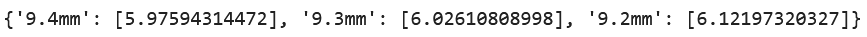

Looking at the sweep results, via `all_sweeps`, we can see that the necessary length is approx 9.35mm.

In [ ]:
bus_02.options.total_length = '9.35mm'

In [ ]:
bus_02_EPR.sim.close()

# EPR

### Energy Participation Ratio (EPR) Analysis (https://arxiv.org/abs/2010.00620)

We can look at the three mode system of qubits 0 and 1, and bus_01 as a whole, working off some of the previous tuning we have already accomplished. 

We will first update qubit 1 and bus_01 assuming previous analysis had already been accomplished.

In [ ]:
q_1.options.pad_gap = '28um'
q_1.options.connection_pads.readout.pad_gap = '20um'
q_1.options.connection_pads.readout.pad_width = '100um'
q_1.options.connection_pads.bus_12.pad_width = '130um'
q_1.options.hfss_inductance = '13.9nH'
bus_01.options.total_length = '9.55mm'
gui.rebuild()

We again setup the simulation as we have done previously, creating an instance of the EPR analysis with `hfss` as the renderer.

In [ ]:
three_mode_EPR = EPRanalysis(design, "hfss")

We then modify the simulation setup options based on the three mode simulation, two qubits and a resonator, we are wanting to run.

In [ ]:
three_mode_EPR.sim.setup.max_passes = 18
three_mode_EPR.sim.setup.max_delta_f = 0.025
three_mode_EPR.sim.setup.n_modes = 3
three_mode_EPR.sim.setup.vars = Dict(Lj0= '14.9 nH', Cj0= '0 fF',
                           Lj1= '13.9 nH', Cj1= '0 fF')

From this point we can run the simulation. We could simply use `run()` to have the full EPR analysis run, but we will use `run_sim()` so that we can check the convergence of the classical simulation before jumping into the EPR analysis portion. In this instance, we want both junctions included in the simulation (as sheet inductances). Any disconnected pins can simply be shorted (default).

In [ ]:
three_mode_EPR.sim.run_sim(name="Three_Mode",
                components=['Q_0', 'Q_1', 'Bus_01'])

In [ ]:
three_mode_EPR.sim.plot_convergences()

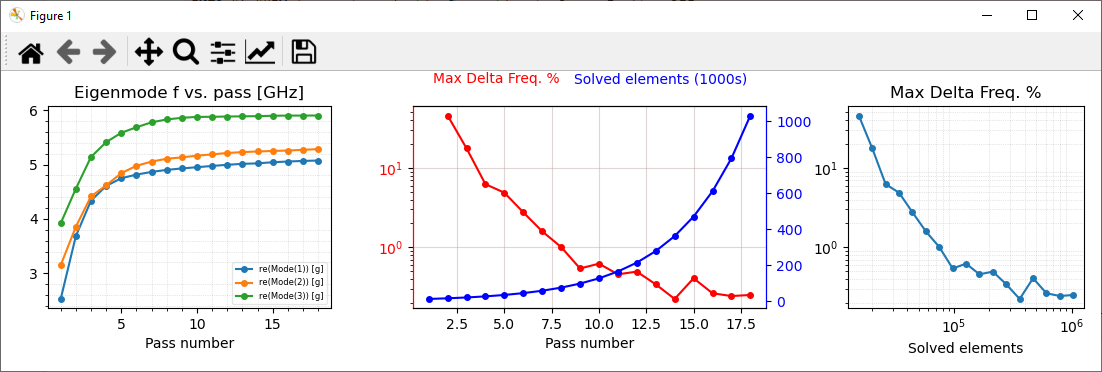

Although these modes appear off, keep in mind that these are the classical modes with out the quantum effects. We do see that the two qubit modes are separated by roughly the desired amount (~200 MHz), which is what we were targeting. We could also again consider looking at the E-fields to confirm the modes of interest are for the correct components.

Being happy with the convergence (although this hasn't converged, we will pretend it has for the sake of the tutorial), we can start to look at the analysis. We want to remove the default EPR setup, and add in that which matches our simulation.

In [ ]:
del three_mode_EPR.setup.junctions['jj']

three_mode_EPR.setup.junctions.jj0 = Dict(rect='JJ_rect_Lj_Q_0_rect_jj', line='JJ_Lj_Q_0_rect_jj_',
                  Lj_variable='Lj0', Cj_variable='Cj0')
three_mode_EPR.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q_1_rect_jj', line='JJ_Lj_Q_1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
three_mode_EPR.setup.sweep_variable = 'Lj0'
three_mode_EPR.setup

In [ ]:
three_mode_EPR.setup

Once all setup, we can run the EPR analysis. Depending on the truncation and simulation sizes, not to mention if many values are being swept across, this analysis can be quite time consuming. Keep this in mind when setting the values, and to avoid fine tuning before having completed faster simulations and analysis.

In [ ]:
three_mode_EPR.run_epr()

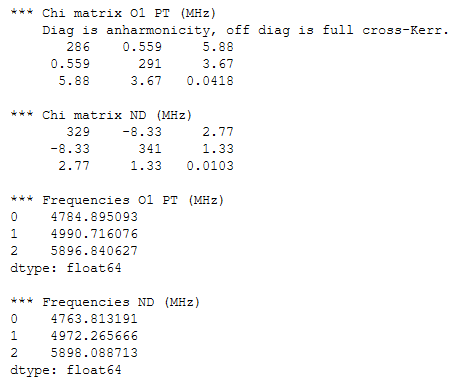

From the matrix, we can see how much each mode (or each qubit and bus) is interacting with each other. (Note: These values are a bit erratic since we did not have a really good convergence of the classical simulations). We could modify the component options, such as `q_0.options.connection_pads.bus_01.pad_width` and `q_1.options.connection_pads.bus_01.pad_width`, in order to get the coupling strength between the two qubits, seen by the off-diagonal values, to the value we are designing for. 

In [ ]:
three_mode_EPR.sim.close()

# GDS Render

Once we have successfully tuned all aspects of the chip to the values we were aiming for, we can export (or render) the layout to a GDS file for fabrication purposes. To do so, we will make an instance of the GDS renderer, modify some options, such as cheesing, make sure we are importing the correct reference file for the junction e-beam layout, and then finally render.

In [ ]:
mt_gds = design.renderers.gds

mt_gds.options

In [ ]:
mt_gds.options.path_filename = '../resources/Fake_Junctions.GDS'

In [ ]:
mt_gds.options.no_cheese.buffer = '40um'
mt_gds.options.max_points = 2555
mt_gds.options.cheese.cheese_0_x = '3um'
mt_gds.options.cheese.cheese_0_y = '3um'
mt_gds.options.cheese.delta_x = '50um'
mt_gds.options.cheese.delta_y = '50um'
mt_gds.options.cheese.view_in_file= {'main': {1: True}}
mt_gds.options.fabricate = True

In [ ]:
mt_gds.export_to_gds("MetalTutorial.gds")

With that, we have successfully designed, simulated, analyzed, tuned, and exported for fabrication our three qubit chip. Hopefully this tutorial has been a helpful introduction to Qiskit Metal and how to use it in your design flow process.